In [1]:
import os, sys, pathlib

REPO_URL = "https://github.com/UmerSR/Connect-Four-RL.git"
WORKSPACE = "/content/Connect-Four-RL"

if not os.path.exists(WORKSPACE):
    !git clone $REPO_URL $WORKSPACE
else:
    %cd $WORKSPACE
    !git pull --ff-only

%cd $WORKSPACE/rl_connect4
sys.path.insert(0, WORKSPACE)
print("CWD:", os.getcwd())

Cloning into '/content/Connect-Four-RL'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87 (from 1)
Receiving objects: 100% (87/87), 44.66 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/Connect-Four-RL/rl_connect4
CWD: /content/Connect-Four-RL/rl_connect4


In [2]:
!pip install -q stable-baselines3[extra] sb3-contrib gymnasium pygame numpy torch pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 21.3 MB/s eta 0:00:00


In [3]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium import spaces

from envs.connect_four_env import ConnectFourEnv as BaseEnv

class ConnectFourEnv(BaseEnv):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(3, self.rows, self.cols),
            dtype=np.float32,
        )

    def _convert_obs(self):
        base_obs = super()._get_obs()
        cur_plane = base_obs["observation"][..., 0]
        opp_plane = base_obs["observation"][..., 1]
        legal_mask = base_obs["action_mask"].astype(np.float32)
        legal_layer = np.tile(legal_mask, (self.rows, 1))
        stacked = np.stack([cur_plane, opp_plane, legal_layer], axis=0).astype(np.float32)
        info = {"legal_moves": legal_mask, "turn": self.current_player + 1}
        return stacked, info

    def reset(self, seed=None, options=None):
        base_obs, info = super().reset(seed=seed, options=options)
        return self._convert_obs()

    def step(self, action):
        _, reward, terminated, truncated, info = super().step(int(action))
        obs, mask_info = self._convert_obs()
        info.update(mask_info)
        return obs, reward, terminated, truncated, info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [4]:
def make_env(seed: int = 0):
    def _init():
        env = ConnectFourEnv()
        env.reset(seed=seed)
        return env
    return _init

class ReinforcePolicy(nn.Module):
    def __init__(self, observation_space: spaces.Box, n_actions: int, hidden_dim: int = 512):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample).shape[1]
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(obs))

def get_masked_action(agent, obs, legal_moves, deterministic=True):
    # Helper to select valid actions by masking out illegal columns.
    obs_tensor = torch.tensor(obs).float().unsqueeze(0).to(agent.device)
    mask_tensor = torch.tensor(legal_moves).to(agent.device)
    with torch.no_grad():
        logits = agent.policy(obs_tensor)
        logits = logits.masked_fill(mask_tensor == 0, -1e9)
        if deterministic:
            action = torch.argmax(logits, dim=1).item()
        else:
            probs = torch.softmax(logits, dim=1)
            action = torch.distributions.Categorical(probs).sample().item()
    return int(action)


In [5]:
from collections import deque

class ReinforceAgent:
    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete, lr: float = 1e-4):
        self.device = device
        self.policy = ReinforcePolicy(observation_space, action_space.n).to(self.device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def act(self, obs, legal_moves):
        obs_t = torch.tensor(obs).float().unsqueeze(0).to(self.device)
        mask_t = torch.tensor(legal_moves).to(self.device)
        logits = self.policy(obs_t)
        logits = logits.masked_fill(mask_t == 0, -1e9)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy().mean()
        return action.item(), log_prob, entropy

def train_reinforce_self_play(
    total_episodes=20000,
    gamma=0.99,
    lr=1e-4,
    entropy_coef=0.01,
    seed=1,
    log_freq=200,
    max_steps=200,
):
    print(f"--- Starting REINFORCE Self-Play Training ({total_episodes} episodes) ---")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = ConnectFourEnv()
    agent = ReinforceAgent(env.observation_space, env.action_space, lr=lr)

    history = {
        "avg_reward": [],
        "avg_length": [],
        "epsilon": [],  # kept for plotting compatibility
        "loss": [],
    }

    ep_rewards_window = deque(maxlen=log_freq)
    ep_lengths_window = deque(maxlen=log_freq)

    for ep in range(1, total_episodes + 1):
        obs, info = env.reset(seed=seed + ep)
        log_probs = []
        rewards = []
        entropies = []
        done = False
        steps = 0

        while not done and steps < max_steps:
            action, log_prob, entropy = agent.act(obs, info["legal_moves"])
            obs, reward, terminated, truncated, info = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            done = terminated or truncated
            steps += 1

        # Compute returns (discounted)
        returns = []
        G = 0.0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=agent.device)
        if returns.numel() > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        log_probs_t = torch.stack(log_probs)
        entropies_t = torch.stack(entropies)
        loss = -(log_probs_t * returns).sum() - entropy_coef * entropies_t.sum()

        agent.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.policy.parameters(), 1.0)
        agent.optimizer.step()

        ep_rewards_window.append(sum(rewards))
        ep_lengths_window.append(steps)

        if ep % log_freq == 0:
            history["avg_reward"].append(float(np.mean(ep_rewards_window)))
            history["avg_length"].append(float(np.mean(ep_lengths_window)))
            history["epsilon"].append(0.0)
            history["loss"].append(float(loss.item()))
            print(f"Episode {ep}/{total_episodes} | reward {history['avg_reward'][-1]:.3f} | len {history['avg_length'][-1]:.1f}")

    return agent, history


In [6]:
# Train with the standard REINFORCE self-play setup
reinforce_agent, history = train_reinforce_self_play(
    total_episodes=30000,
    lr=1e-4,
    gamma=0.99,
    entropy_coef=0.01,
    log_freq=500,
)

# Save after the main run
torch.save(reinforce_agent.policy.state_dict(), "reinforce_connect4.pth")

--- Starting REINFORCE Self-Play Training (30000 episodes) ---
Episode 500/30000 | reward 1.240 | len 21.2
Episode 1000/30000 | reward 1.240 | len 21.3
Episode 1500/30000 | reward 1.256 | len 22.0
Episode 2000/30000 | reward 1.239 | len 20.8
Episode 2500/30000 | reward 1.241 | len 21.7
Episode 3000/30000 | reward 1.243 | len 21.4
Episode 3500/30000 | reward 1.246 | len 21.5
Episode 4000/30000 | reward 1.230 | len 20.9
Episode 4500/30000 | reward 1.230 | len 20.8
Episode 5000/30000 | reward 1.260 | len 21.9
Episode 5500/30000 | reward 1.240 | len 21.2
Episode 6000/30000 | reward 1.251 | len 21.8
Episode 6500/30000 | reward 1.250 | len 21.9
Episode 7000/30000 | reward 1.240 | len 20.9
Episode 7500/30000 | reward 1.215 | len 20.3
Episode 8000/30000 | reward 1.242 | len 21.5
Episode 8500/30000 | reward 1.247 | len 21.5
Episode 9000/30000 | reward 1.232 | len 21.2
Episode 9500/30000 | reward 1.252 | len 21.7
Episode 10000/30000 | reward 1.230 | len 20.8
Episode 10500/30000 | reward 1.242 | 

In [7]:
# Secondary save for quick loading of the whole agent object
torch.save(reinforce_agent.state_dict() if hasattr(reinforce_agent, 'state_dict') else reinforce_agent.policy.state_dict(), "reinforce_connect4_policy.pth")

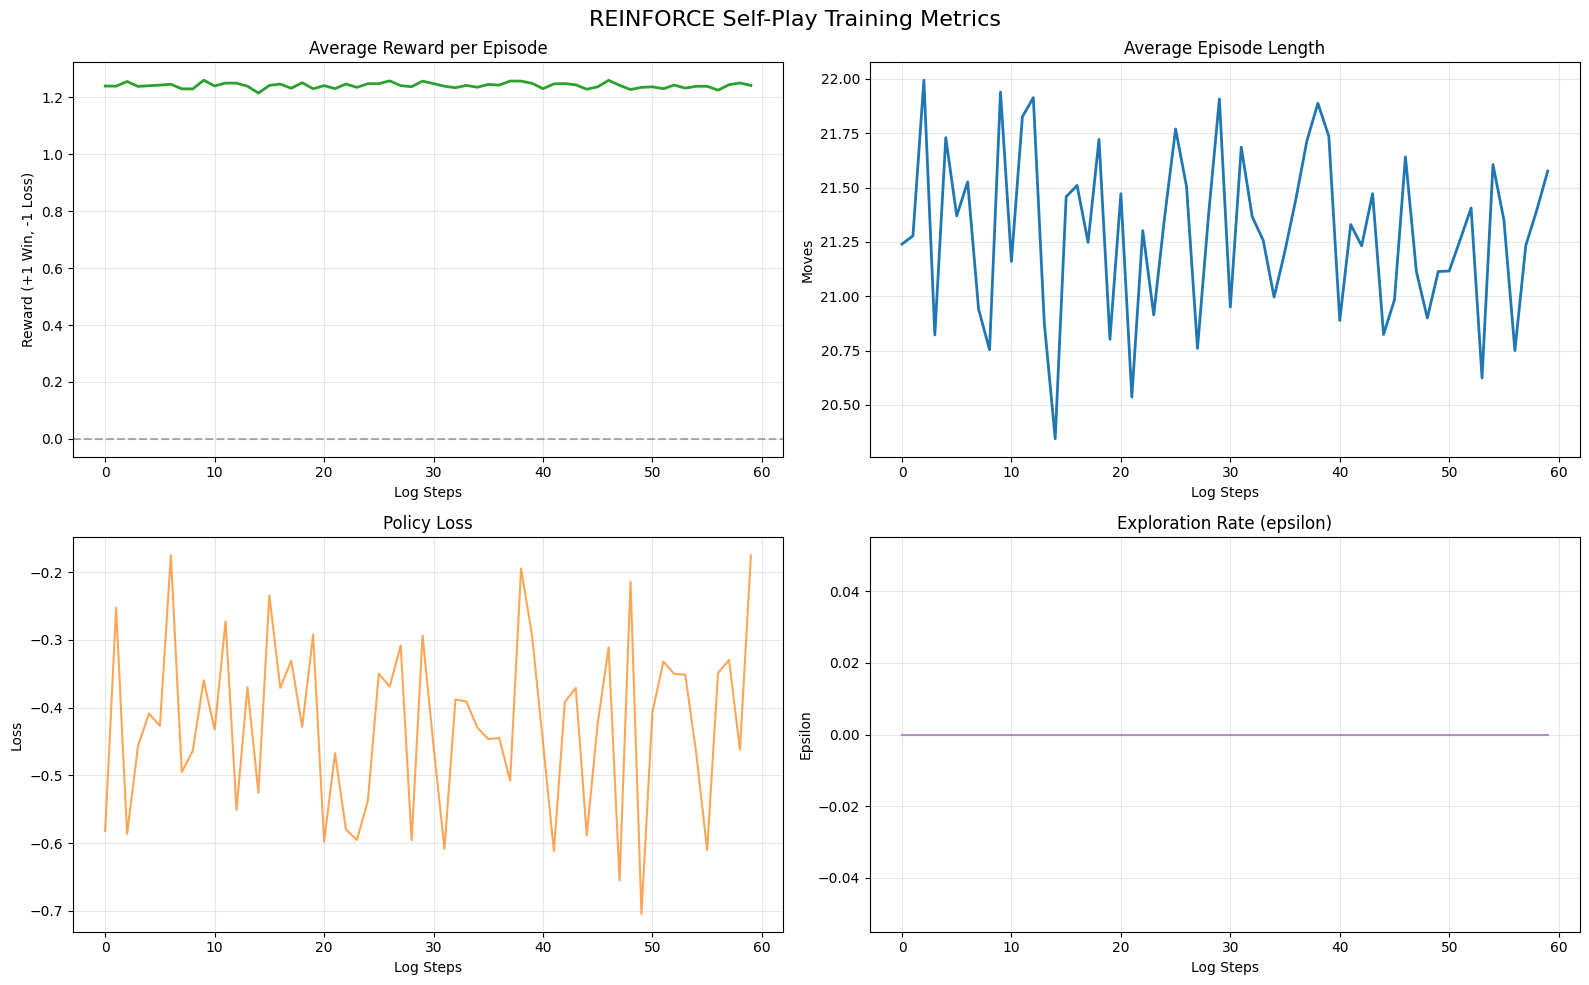

In [8]:
def plot_metrics(history):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('REINFORCE Self-Play Training Metrics', fontsize=16)

    axs[0, 0].plot(history['avg_reward'], color='#2ca02c', linewidth=2)
    axs[0, 0].set_title("Average Reward per Episode")
    axs[0, 0].set_ylabel("Reward (+1 Win, -1 Loss)")
    axs[0, 0].set_xlabel("Log Steps")
    axs[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axs[0, 0].grid(True, alpha=0.3)

    axs[0, 1].plot(history['avg_length'], color='#1f77b4', linewidth=2)
    axs[0, 1].set_title("Average Episode Length")
    axs[0, 1].set_ylabel("Moves")
    axs[0, 1].set_xlabel("Log Steps")
    axs[0, 1].grid(True, alpha=0.3)

    axs[1, 0].plot(history['loss'], color='#ff7f0e', alpha=0.7)
    axs[1, 0].set_title("Policy Loss")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].set_xlabel("Log Steps")
    axs[1, 0].grid(True, alpha=0.3)

    axs[1, 1].plot(history['epsilon'], color='#9467bd', alpha=0.7)
    axs[1, 1].set_title("Exploration Rate (epsilon)")
    axs[1, 1].set_ylabel("Epsilon")
    axs[1, 1].set_xlabel("Log Steps")
    axs[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metrics(history)

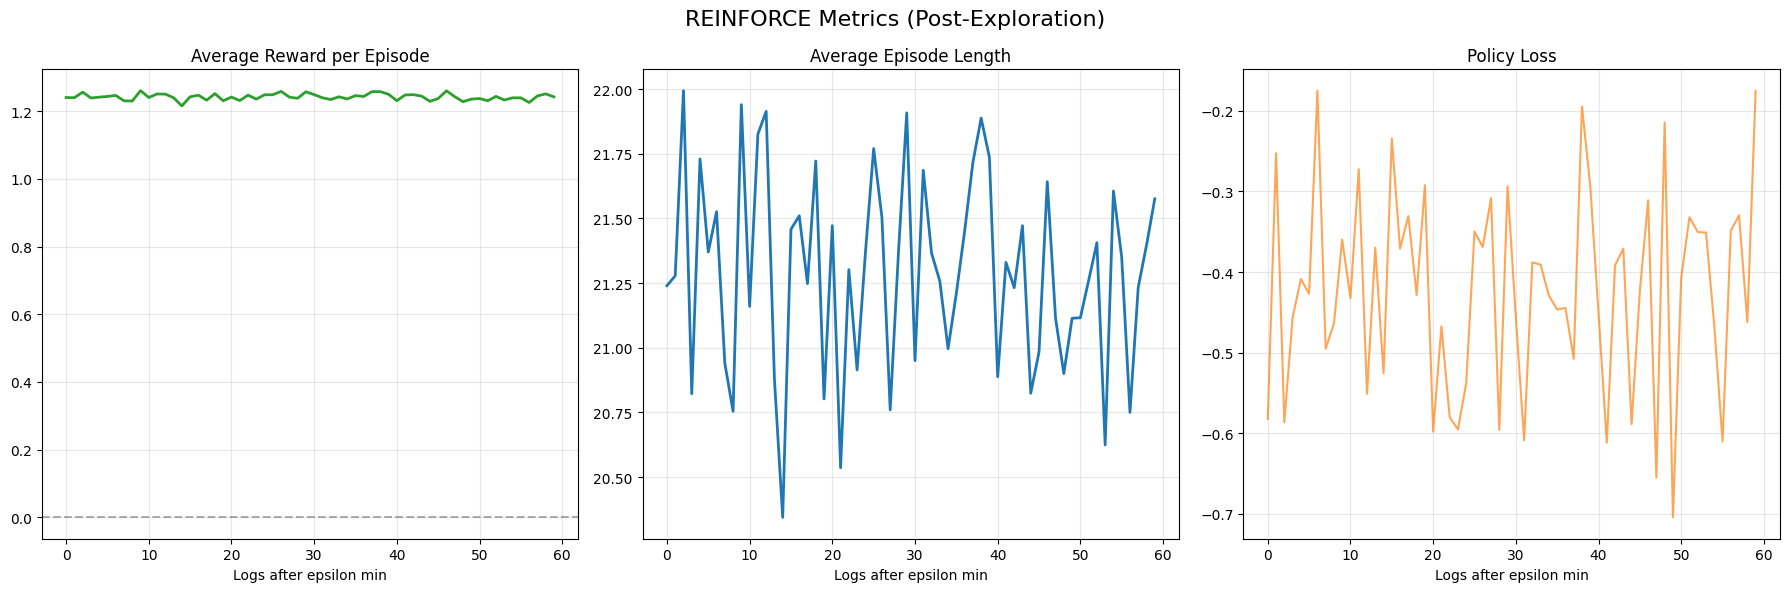

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics_post_exploration(history):
    # Use entries after exploration finishes (epsilon at its minimum)
    eps = np.array(history.get('epsilon', []), dtype=float)
    if eps.size == 0:
        print('No epsilon history found.')
        return

    final_eps = eps.min() if eps.size else 0.0
    zero_idx = np.where(eps <= final_eps + 1e-8)[0]
    start = int(zero_idx[0]) if zero_idx.size > 0 else 0

    sliced = {k: v[start:] for k, v in history.items() if isinstance(v, list)}
    if not sliced or len(sliced.get('avg_reward', [])) == 0:
        print('No data after exploration phase.')
        return

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('REINFORCE Metrics (Post-Exploration)', fontsize=16)

    axs[0].plot(sliced['avg_reward'], color='#2ca02c', linewidth=2)
    axs[0].set_title('Average Reward per Episode')
    axs[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axs[0].grid(True, alpha=0.3)

    axs[1].plot(sliced['avg_length'], color='#1f77b4', linewidth=2)
    axs[1].set_title('Average Episode Length')
    axs[1].grid(True, alpha=0.3)

    axs[2].plot(sliced['loss'], color='#ff7f0e', alpha=0.7)
    axs[2].set_title('Policy Loss')
    axs[2].grid(True, alpha=0.3)

    # Set x-labels for all
    for ax in axs:
        ax.set_xlabel('Logs after epsilon min')

    plt.tight_layout()
    plt.show()

plot_metrics_post_exploration(history)

In [10]:
def evaluate_agent(agent, n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    wins = 0
    losses = 0
    draws = 0

    for i in range(n_games):
        obs, info = env.reset()
        done = False

        # Randomly decide if Agent is Player 1 or Player 2
        agent_player_id = 1 if i % 2 == 0 else -1

        while not done:
            # Check whose turn it is
            current_turn = info.get('turn', 1)  # fallback to Player 1 if not provided

            legal_moves = info['legal_moves']

            if current_turn == agent_player_id:
                action = get_masked_action(agent, obs, legal_moves, deterministic=True)
            else:
                valid_cols = [c for c in range(env.cols) if legal_moves[c] == 1]
                action = random.choice(valid_cols)

            # Step
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if done:
                # If reward is 1, the CURRENT player won.
                # If reward is 0, it's a draw.
                if reward == 1:
                    if current_turn == agent_player_id:
                        wins += 1
                    else:
                        losses += 1
                else:
                    draws += 1

    print(f"Results over {n_games} games:")
    print(f"Wins: {wins} ({wins/n_games*100:.1f}%)")
    print(f"Losses: {losses} ({losses/n_games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/n_games*100:.1f}%)")

    return wins, losses, draws

# Run Evaluation
print("Evaluating Agent vs Random...")
evaluate_agent(reinforce_agent, n_games=100)

Evaluating Agent vs Random...
Results over 100 games:
Wins: 46 (46.0%)
Losses: 54 (54.0%)
Draws: 0 (0.0%)


(46, 54, 0)

Agent (Red/1) vs Random (Yellow/2)


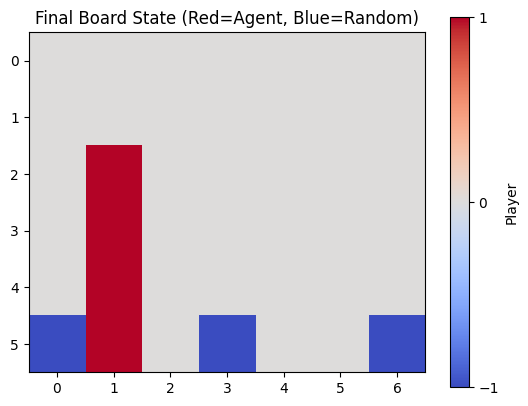

Winner: Agent


In [11]:
import matplotlib.pyplot as plt
import random

def play_demo_game(agent):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    print('Agent (Red/1) vs Random (Yellow/2)')
    agent_player = 1
    last_actor = None
    while not done:
        legal_moves = info['legal_moves']
        actor = info['turn']
        last_actor = actor
        if actor == agent_player:
            action = get_masked_action(agent, obs, legal_moves, deterministic=True)
        else:
            valid_cols = [c for c in range(env.cols) if legal_moves[c] == 1]
            action = random.choice(valid_cols)
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
    board = env.board.copy().astype(int)
    board_vis = board.copy()
    board_vis[board_vis == 2] = -1
    plt.imshow(board_vis, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Final Board State (Red=Agent, Blue=Random)')
    plt.colorbar(ticks=[-1, 0, 1], label='Player')
    plt.grid(False)
    plt.show()
    if reward == 1:
        winner = 'Agent' if last_actor == agent_player else 'Random'
        print(f'Winner: {winner}')
    else:
        print('Draw!')

play_demo_game(reinforce_agent)

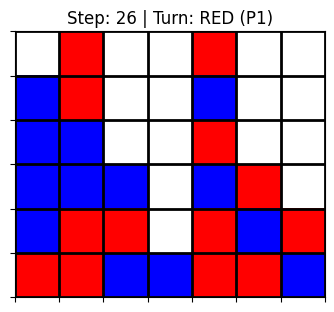

Game Over! Winner: BLUE


In [12]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output
import matplotlib.pyplot as plt
import time


def watch_self_play(agent, sleep_time=0.5):
    env = ConnectFourEnv()
    obs, info = env.reset()
    done = False
    agent.policy.eval()
    fig, ax = plt.subplots(figsize=(4, 4))
    step_count = 0
    last_actor = None
    while not done:
        actor = info['turn']
        last_actor = actor
        action = get_masked_action(agent, obs, info['legal_moves'], deterministic=False)
        obs, reward, term, trunc, info = env.step(action)
        done = term or trunc
        step_count += 1
        board = env.board.copy().astype(int)
        board_vis = board.copy()
        board_vis[board_vis == 2] = -1
        ax.clear()
        cmap = plt.cm.colors.ListedColormap(['blue', 'white', 'red'])
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
        ax.imshow(board_vis, cmap=cmap, norm=norm)
        ax.grid(which='major', color='black', linestyle='-', linewidth=2)
        ax.set_xticks(np.arange(-.5, 7, 1))
        ax.set_yticks(np.arange(-.5, 6, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        turn_name = 'RED (P1)' if info['turn'] == 1 else 'BLUE (P2)'
        ax.set_title(f'Step: {step_count} | Turn: {turn_name}')
        clear_output(wait=True)
        display(fig)
        time.sleep(sleep_time)
    plt.close()
    if reward == 1:
        winner = 'RED' if last_actor == 1 else 'BLUE'
        print(f'Game Over! Winner: {winner}')
    else:
        print("Game Over! It's a DRAW.")

watch_self_play(reinforce_agent, sleep_time=0.3)


# Run the animation
watch_self_play(reinforce_agent, sleep_time=0.3)

In [13]:
def evaluate_self_play(agent, n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    p1_wins = 0
    p2_wins = 0
    draws = 0

    print(f"Running {n_games} self-play games (Stochastic Mode)...")

    for _ in range(n_games):
        obs, info = env.reset()
        done = False

        while not done:
            actor = info['turn']
            action = get_masked_action(agent, obs, info['legal_moves'], deterministic=False)
            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

            if done:
                if reward == 1:
                    if actor == 1:
                        p1_wins += 1
                    else:
                        p2_wins += 1
                else:
                    draws += 1

    print("-" * 30)
    print(f"Self-Play Results ({n_games} Games):")
    print(f"Player 1 (Agent) Wins: {p1_wins} ({p1_wins/n_games*100:.1f}%)")
    print(f"Player 2 (Agent) Wins: {p2_wins} ({p2_wins/n_games*100:.1f}%)")
    print(f"Draws:                 {draws} ({draws/n_games*100:.1f}%)")
    print("-" * 30)

    # Interpretation
    if p1_wins > p2_wins + 20:
        print("Analysis: Strong First-Player Advantage detected.")
    elif abs(p1_wins - p2_wins) <= 20:
        print("Analysis: The agent is balanced (defends as well as it attacks).")
    else:
        print("Analysis: The agent actually plays better as Player 2 (Counter-Attacker).")

evaluate_self_play(reinforce_agent, n_games=500)

Running 500 self-play games (Stochastic Mode)...
------------------------------
Self-Play Results (500 Games):
Player 1 (Agent) Wins: 273 (54.6%)
Player 2 (Agent) Wins: 224 (44.8%)
Draws:                 3 (0.6%)
------------------------------
Analysis: Strong First-Player Advantage detected.


In [14]:
class RandomAgent:
    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]
        return random.choice(valid_cols)

class GreedyAgent:
    """
    A baseline that:
    1. Prefers the center column if it is legal.
    2. Otherwise plays random.
    """
    def __init__(self):
        self.env = ConnectFourEnv() # Internal env for simulation

    def get_action(self, obs, info):
        legal_moves = info['legal_moves']
        valid_cols = [c for c in range(7) if legal_moves[c] == 1]

        if 3 in valid_cols:
            return 3

        # 3. Random
        return random.choice(valid_cols)

def run_evaluation_metrics(agent, opponent_type="random", n_games=100):
    env = ConnectFourEnv()
    agent.policy.eval()

    rewards, lengths = [], []
    outcomes = {"win": 0, "loss": 0, "draw": 0}

    opponent = RandomAgent()  # or your other baseline
    print(f"Evaluating: REINFORCE Agent vs {opponent_type.capitalize()} ({n_games} games)...")

    agent_player = 1  # agent is Red/Player 1

    for _ in range(n_games):
        obs, info = env.reset()
        done = False
        steps = 0
        episode_reward = 0
        last_actor = None

        while not done:
            steps += 1
            legal_moves = info["legal_moves"]
            actor = info["turn"]
            last_actor = actor

            if actor == agent_player:
                action = get_masked_action(agent, obs, legal_moves, deterministic=True)
            else:
                action = opponent.get_action(obs, info)

            obs, reward, term, trunc, info = env.step(action)
            done = term or trunc

        # Outcome relative to the agent (player 1)
        if reward == 1:
            episode_reward = 1 if last_actor == agent_player else -1
            if last_actor == agent_player:
                outcomes["win"] += 1
            else:
                outcomes["loss"] += 1
        else:
            episode_reward = 0
            outcomes["draw"] += 1

        rewards.append(episode_reward)
        lengths.append(steps)

    avg_reward = np.mean(rewards); std_reward = np.std(rewards)
    avg_len = np.mean(lengths); win_rate = outcomes["win"] / n_games * 100
    results = {
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_length": avg_len,
        "win_rate": win_rate,
        "outcomes": outcomes,
    }
    print(f"  > Average Reward: {avg_reward:.3f} +/- {std_reward:.3f}")
    print(f"  > Average Length: {avg_len:.1f} moves")
    print(f"  > Win Rate:       {win_rate:.1f}%")
    return results

# Run the standard evaluation
metrics = run_evaluation_metrics(reinforce_agent, "random", n_games=200)

Evaluating: REINFORCE Agent vs Random (200 games)...
  > Average Reward: 0.670 +/- 0.742
  > Average Length: 10.4 moves
  > Win Rate:       83.5%
